In [157]:
from psycopg2 import connect
import pandas.io.sql as pandasql
import pandas as pd
import configparser
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib as mpl
import copy

CONFIG = configparser.ConfigParser()
CONFIG.read('C:\\Users\\rrodger\\reed.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

In [98]:
sql_15 = '''
WITH yr as (
    SELECT EXTRACT(YEAR FROM datetime_bin) as year, 
        analysis_id, 
        datetime_bin::time as time, 
        percentile_cont(0.5) WITHIN GROUP(ORDER BY bt.tt) as yr_tt,
        CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END as weekday

    FROM bluetooth.aggr_15min bt
        LEFT OUTER JOIN ref.holiday hol ON (bt.datetime_bin::DATE = hol.dt)
    
    WHERE hol.dt is NULL

    GROUP BY analysis_id, 
        datetime_bin::time, 
        EXTRACT(YEAR FROM datetime_bin),
        CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END)

SELECT bt.tt, 
	yr.yr_tt, 
	bt.datetime_bin, 
	bt.analysis_id,
	EXTRACT(ISODOW FROM datetime_bin) as weekday,
	aa.report_name,
	yr.weekday as workingday
FROM bluetooth.aggr_15min bt
	INNER JOIN yr ON (yr.analysis_id = bt.analysis_id 
		AND EXTRACT(year FROM bt.datetime_bin) = yr.year 
		AND bt.datetime_bin::time = yr.time
		AND CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END = yr.weekday)
	INNER JOIN bluetooth.all_analyses aa ON (bt.analysis_id = aa.analysis_id)
    LEFT OUTER JOIN ref.holiday hol ON (bt.datetime_bin::DATE = hol.dt)
    
WHERE left(aa.report_name, 4) = 'DT-0'
    AND hol.dt is NULL
'''

observations_15 = pandasql.read_sql(sql_15, con)

In [59]:
start = pd.Timestamp('2017-10-04 00:00:00')
end = pd.Timestamp('2017-10-05 00:00:00')
colors = ['#0f6006', '#3b86f7']

#(startobservations_30['report_name'].unique() <= observations.datetime_bin) & (observations.datetime_bin <= end)

#observations = observations.sort_values(['datetime_bin'])


In [60]:
observations_30['report_name'].unique()

array(['DT-0001.College-EB_Bathurst-to-University',
       'DT-0002. College-EB_University-to-Parliament',
       'DT-0003. College-WB_Parliament-to-University',
       'DT-0004. College-WB_University-to-Bathurst',
       'DT-0005. Dundas-EB_Roncesvalles-to-Dufferin',
       'DT-0006. Dundas-EB_Dufferin-to-Bathurst',
       'DT-0007. Dundas-EB_Bathurst-to-Spadina',
       'DT-0008. Dundas-EB_Spadina-to-University',
       'DT-0009. Dundas-EB_University-to-Yonge',
       'DT-0010. Dundas-EB_Yonge-to-Jarvis',
       'DT-0011. Dundas-EB_Jarvis-to-Parliament',
       'DT-0012. Dundas-WB_Parliament-to-Jarvis',
       'DT-0013. Dundas-WB_Jarvis-to-Yonge',
       'DT-0014. Dundas-WB_Yonge-to-University',
       'DT-0015. Dundas-WB_University-to-Spadina',
       'DT-0016. Dundas-WB_Spadina-to-Bathurst',
       'DT-0017. Dundas-WB_Bathurst-to-Dufferin',
       'DT-0018. Dundas-WB_Dufferin-to-Roncesvalles',
       'DT-0019. Queen-EB_Roncesvalles-to-Dufferin',
       'DT-0020. Queen-EB_Dufferin-t

In [61]:
r_name = 'DT-0019. Queen-EB_Roncesvalles-to-Dufferin'

In [123]:
def plot_base(observations):
    
    segments = {'Week' : observations[(observations['report_name'] == r_name) & 
                         (observations['workingday'] == 'Work')].sort_values(['datetime_bin']),
                'Weekend' : observations[(observations['report_name'] == r_name) & 
                            (observations['workingday'] == 'Weekend')].sort_values(['datetime_bin'])}
        
        
    fig, work = plt.subplots(1, 1, figsize = (16,16))
    
    weekend = work.twinx()
    weekend = work.twiny()
    days = [work, weekend]
    
    for i, (color, WD) in enumerate(zip(colors, ['Weekend', 'Week'])):
  #      handles.append(mpl.patches.Patch(color = color, label = WD))
        
   # weekday = []

        days[i].plot_date(x = segments[WD].datetime_bin.dt.time,
                             y = segments[WD].yr_tt,
                             xdate = True,
                             fmt = '-o',
                             c = color)
    #weekday.append([])
    #for j, WD in enumerate(['F', 'Sa', 'Su']):
     #   weekday[i].append(analysis[i].twinx())
      #  weekday[i][j].plot_date(x = segments[a_id][WD].datetime_bin,
       #                          y = segments[a_id][WD].yr_tt,
        #                         xdate = True,
         #                        fmt = '-o',
          #                       c = colors[j])
            
    days[1].get_xaxis().set_visible(False)
    days[1].get_yaxis().set_visible(False)
    plt.title('Baseline for ' + r_name + ' by Day')
   # analysis[i].set_xlim(pd.Timestamp(2017, 10, 26, 0, 0, 0), pd.Timestamp(2017, 10, 30, 0, 0))
    days[1].xaxis.set_label_text('Time')
    days[1].yaxis.set_label_text('Travel Time')
    plt.gcf().autofmt_xdate()
    plt.show()

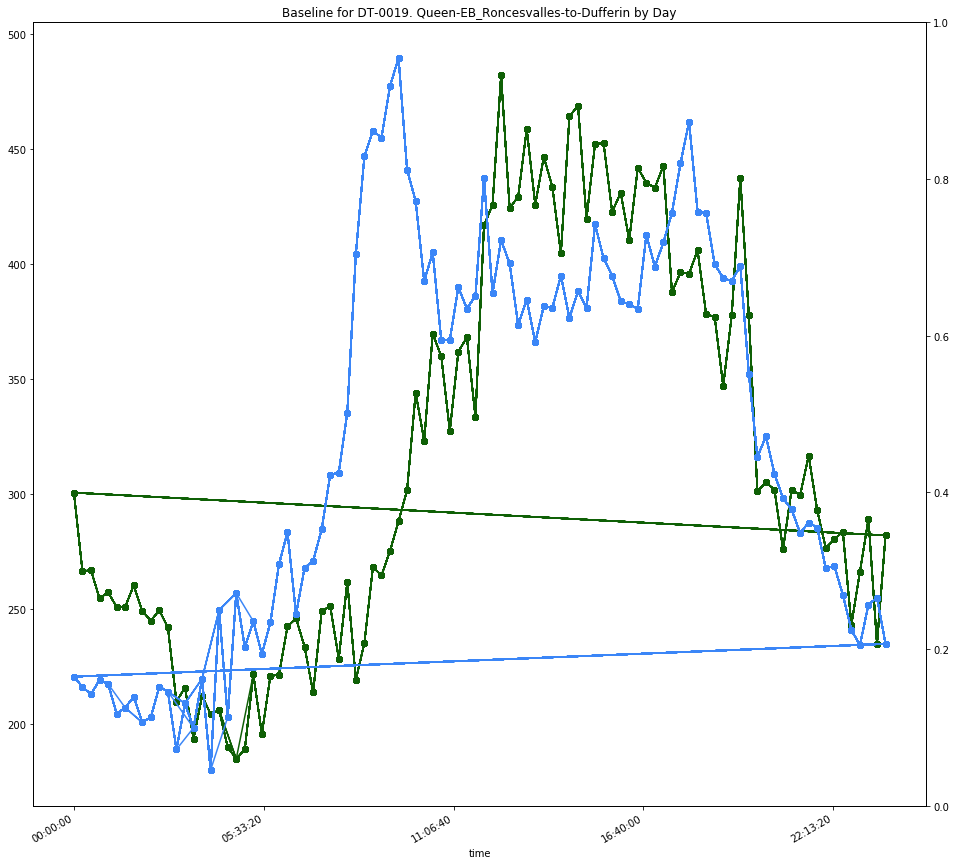

In [125]:
plot_base(observations_15)

In [102]:
observations_15['workingday'].unique()
#{'Week' : observations_15[(observations_15['report_name'] == r_name) & 
 #                        (observations_15['workday'] == 'Work')].sort_values(['datetime_bin']),
  #              'Weekend' : observations_15[(observations_15['report_name'] == r_name) & 
   #                         (observations_15['workday'] == 'Weekend')].sort_values(['datetime_bin'])}

array(['Weekend', 'Work'], dtype=object)

In [127]:
sql_30 = '''
WITH yr as (
    SELECT EXTRACT(YEAR FROM datetime_bin) as year, 
        analysis_id, 
        datetime_bin::time as time, 
        percentile_cont(0.5) WITHIN GROUP(ORDER BY bt.travel_time) as yr_tt,
        CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END as weekday

    FROM dt_30min_agg bt
        LEFT OUTER JOIN ref.holiday hol ON (bt.datetime_bin::DATE = hol.dt)
    
    WHERE hol.dt is NULL

    GROUP BY analysis_id, 
        datetime_bin::time, 
        EXTRACT(YEAR FROM datetime_bin),
        CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END)

SELECT bt.travel_time, 
	yr.yr_tt, 
	bt.datetime_bin, 
	bt.analysis_id,
	EXTRACT(ISODOW FROM datetime_bin) as weekday,
	aa.report_name,
	yr.weekday as workingday
FROM dt_30min_agg bt
	INNER JOIN yr ON (yr.analysis_id = bt.analysis_id 
		AND EXTRACT(year FROM bt.datetime_bin) = yr.year 
		AND bt.datetime_bin::time = yr.time
		AND CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END = yr.weekday)
	INNER JOIN bluetooth.all_analyses aa ON (bt.analysis_id = aa.analysis_id)
    LEFT OUTER JOIN ref.holiday hol ON (bt.datetime_bin::DATE = hol.dt)
    
WHERE hol.dt is NULL
'''
observations_30 = pandasql.read_sql(sql_30, con)

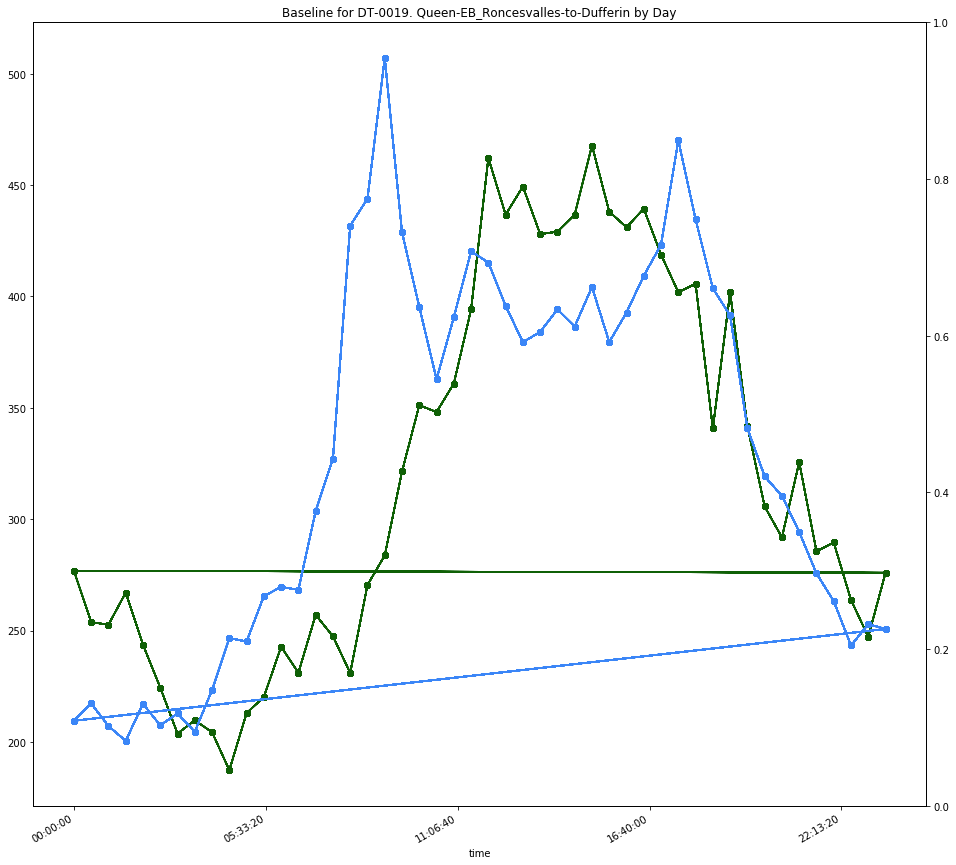

In [128]:
plot_base(observations_30)

In [21]:
def WOY(x, W):
    return x.weekofyear == W

In [170]:
weeks = {W : observations_30[(observations_30['report_name'] == r_name) & 
             observations_30['datetime_bin'].apply(WOY, args = (W,))]
        for W in observations_30.datetime_bin.apply(lambda x : x.weekofyear).unique()}

In [171]:
temp = {}
for week, df in weeks.items():
    if not df.empty:
        temp[week] = weeks[week]
weeks = temp

In [172]:
weeks

{38:        travel_time       yr_tt        datetime_bin  analysis_id  weekday  \
 27521   289.659091  276.858059 2017-09-23 00:00:00      1453535      6.0   
 27522   278.190476  276.858059 2017-09-24 00:00:00      1453535      7.0   
 27549   219.750000  209.533333 2017-09-22 00:00:00      1453535      5.0   
 27554   259.600000  253.815789 2017-09-23 00:30:00      1453535      6.0   
 27560   232.933333  253.815789 2017-09-24 00:30:00      1453535      7.0   
 27587   267.141026  217.309524 2017-09-22 00:30:00      1453535      5.0   
 27596   263.433333  252.636905 2017-09-24 01:00:00      1453535      7.0   
 27600   239.333333  252.636905 2017-09-23 01:00:00      1453535      6.0   
 27627   242.805556  207.153846 2017-09-22 01:00:00      1453535      5.0   
 27628   266.444444  267.055556 2017-09-24 01:30:00      1453535      7.0   
 27637   250.555556  267.055556 2017-09-23 01:30:00      1453535      6.0   
 27640   199.500000  200.522727 2017-09-22 01:30:00      1453535      5.

In [176]:
fig, ax = plt.subplots(len(weeks.keys()), 1, sharex = True, figsize = (16, 16))
for i, week in enumerate(weeks):
    weeks[week].plot(x = 'datetime_bin',
                    y = 'travel_time',
                    ax = ax[i],
                    legend = week,
                    title = week)
    #make some graphs

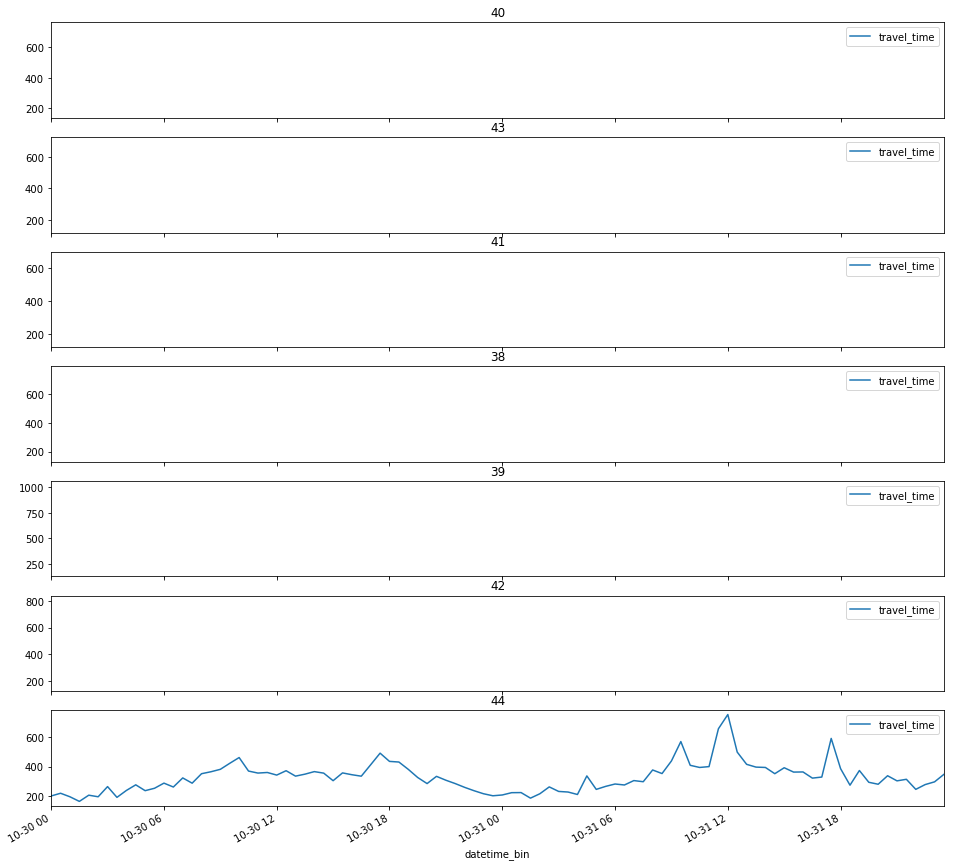

In [177]:
plt.show()

In [55]:
weeks[week][weeks[week].report_name == r_name]

,travel_time,yr_tt,datetime_bin,analysis_id,weekday,report_name
24,223.793651,229.029412,2017-09-14 00:00:00,1453138,4.0,DT-0001.College-EB_Bathurst-to-University
32,234.567708,241.526316,2017-09-15 00:00:00,1453138,5.0,DT-0001.College-EB_Bathurst-to-University
37,290.833333,282.460784,2017-09-16 00:00:00,1453138,6.0,DT-0001.College-EB_Bathurst-to-University
41,293.500000,293.500000,2017-09-17 00:00:00,1453138,7.0,DT-0001.College-EB_Bathurst-to-University
71,224.578431,224.578431,2017-09-14 00:30:00,1453138,4.0,DT-0001.College-EB_Bathurst-to-University
80,275.677083,233.690476,2017-09-15 00:30:00,1453138,5.0,DT-0001.College-EB_Bathurst-to-University
86,311.528369,276.944444,2017-09-16 00:30:00,1453138,6.0,DT-0001.College-EB_Bathurst-to-University
90,288.596899,309.878378,2017-09-17 00:30:00,1453138,7.0,DT-0001.College-EB_Bathurst-to-University
116,221.980392,245.441176,2017-09-14 01:00:00,1453138,4.0,DT-0001.College-EB_Bathurst-to-University
128,253.547619,246.166667,2017-09-15 01:00:00,1453138,5.0,DT-0001.College-EB_Bathurst-to-University


In [ ]:
colors = ['#004B85','#F2756D']

In [ ]:
def getfig(analysis_id, week):
    fig, BT = plt.subplots(figsize = (16,8))
    year = BT.twinx()
    year = BT.twiny()
    BT.plot_date(x = segments[analysis_id]['datetime_bin'],
                y = segments[analysis_id]['tt'],
                xdate = True,
                ydate = False,
                c = colors[0],
                fmt = '-o')
    year.plot_date(x = segments[analysis_id]['datetime_bin'],
                  y = segments[analysis_id]['yr_tt'],
                  xdate = True,
                  ydate = False,
                  c = colors[1],
                  fmt = '-o')
    
    BT.xaxis.set_label_text('Timestamp')
    BT.yaxis.set_label_text('Travel Time')
    
    #BT.xaxis.set_major_locator(mpl.dates.MonthLocator(bymonth=range(1,13,6)))
    
    plt.title('Bluetooth VS Average Day on ' + str(analysis_id))
    
    BT.legend(loc = 'upper right')
    year.legend(loc= 'upper left')
    
    year.get_xaxis().set_visible(False)
    
    return fig

In [ ]:
for i, analysis_id in enumerate(segments):
    plt.show(getfig(analysis_id))
    if i > 5:
        break

In [ ]:
observations['report_name']